In [2]:
# to use pandas dataframes
import pandas as pd

import numpy as np

# import MongoDB modules
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline

# we can always use more time
import time

In [21]:
#
# Pipeline for model/system
#
# Scrape Data         -> Process data        -> Fit Model        -> Eval Model
#
# have game reviews     read in data         Prob easy           hmm
# for sparse crappy     into dataframe
# first model


# connect to the hosted MongoDB instance
db = MongoClient('mongodb://localhost:27017/')["capstone"]

source_collection = db.selenium_game_review_scrape

##########################################################
# figure out the shape of the resulting numpy 2d matrix
##########################################################

def get_unique_users(collection):
    '''
    return a set that contains all of the user_ids in a unique
    manner
    
    returns:
    set of user_ids
    '''
    
    # store the users as a set so they're unique
    users = set()

    non_unique_users = 0

    # step through each doc (which is a game's worth of reviews)
    for doc in collection.find():

        # step through the positive reviews, adding the user to the users set
        [users.add(user["user"])for user in doc["positive_reviews"]]

        # find the non-unique users
        non_unique_users += len(doc["positive_reviews"])

        # step through the negative reviews, adding the user to the users set
        [users.add(user["user"])for user in doc["negative_reviews"]]

        # find the non-unique users
        non_unique_users += len(doc["negative_reviews"])

    print "Unique users:", len(users)
    print "non-Unique users:", non_unique_users

def load_game_reviews_into_table(collection):
    '''
    Spark seems to ingest data via a big list and goes from there
    so make a dataframe that looks like
    
    user | app_id | rating (positive)
    '''
    start_time = time.time()
    data = []
    
    for game in collection.find():
        print "##{}##########################".format(time.time() - start_time)
        
        for review in game["positive_reviews"]:
            data.append({"app_id":game["app_id"], "user":review["user"], "rating":review["rating"]})
            
    df = pd.DataFrame(data, cols=["app_id", "user", "rating"])
    
    return df

def load_game_reviews_to_matrix(users, collection):
    '''
    create a 2d zero matrix that has as many rows as <users>
    which is a set of unique users. There are as many columns 
    as there are games in the collection of review data provided.
    
    Then go through and populate the row/column location data with
    reviews that users have actually made.
    
    Return a 2d numpy array of (users, games) shape with review data
    '''
    
    start_time = time.time()
    
    columns = ["user"]

    for doc in source_collection.find():
        columns.append(doc["app_id"].encode("ascii", "ignore"))
        
    # add one to shape for the user name
    data = pd.DataFrame(np.zeros(shape=(len(users), (source_collection.find().count() + 1 ))))
    
    data.columns = columns

    # cast users to a list so that it has order that we can use
    user_list = list(users)
    
    data["user"] = user_list
    
    # assign values like this: data.loc["Heights", "413150"] = -17
    
    # step through each game:
    for game in collection.find():
        print
        print "##{}##########################".format(time.time() - start_time)
        print "Working on", game["app_id"]
        print
        print
        
        # step through positive reviews for the game and set the corresponding value
        # in the dataframe
        for idx, review in enumerate(game["positive_reviews"]):
            #print "{} {:<20} {:<40}\r".format(idx, game["app_id"], review["user"]),
            
            # each review should look like:
            # {"user": <name>, "rating":0 or 1, "review": "text"}
            
            # find the matching location and change the value to the rating
            data.loc[user_list.index(review["user"]), game["app_id"]] = review["rating"]
        
        print
        
        # step through all of the negative reviews as well and again set the user
        # ratings at the corresponding user/game location
        for idy, review in enumerate(game["negative_reviews"]):
            #print "{} {:<20} {:<40}\r".format(idy, game["app_id"], review["user"]),
            
            # find the matching location and change the value to the rating
            data.loc[user_list.index(review["user"]), game["app_id"]] = -1
            
        print
        
    print "total_time:", (time.time() - start_time)
    return data
        

In [6]:
data = load_game_reviews_to_matrix(users, source_collection)

data.head(20)


##0.404658079147##########################
Working on 413150





##6.25000810623##########################
Working on 367520





##10.3035919666##########################
Working on 286160





##15.6181571484##########################
Working on 246620





##20.8994810581##########################
Working on 257850





##25.8958079815##########################
Working on 105600





##34.0064389706##########################
Working on 211820





##41.1771650314##########################
Working on 311690





##46.3898501396##########################
Working on 233450





##53.5387921333##########################
Working on 250760





##57.5889539719##########################
Working on 427520





##61.7730820179##########################
Working on 239820





##67.7232780457##########################
Working on 48000





##73.1062679291##########################
Working on 371200





##75.6351299286##########################
Working on 312530





##79.8261089325#########

,user,413150,367520,286160,246620,257850,105600,211820,311690,233450,...,251570,326460,22000,433340,206190,248820,308420,391540,224760,212680
0,AGuyCalledSquid,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Vaycron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ray_of_Light,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76561198156561647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,76561198031057031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,569947609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,strajerul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,76561198100817737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,76561198053842338,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,76561197973300271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
info = load_game_reviews_into_table(source_collection)


##0.0115790367126##########################

##0.0128829479218##########################

##0.0394520759583##########################

##0.0415449142456##########################

##0.0435180664062##########################

##0.0452928543091##########################

##0.0476279258728##########################

##0.0494170188904##########################

##0.0766890048981##########################

##0.0788969993591##########################

##0.08061003685##########################

##0.0823369026184##########################

##0.0841228961945##########################

##0.0859849452972##########################

##0.0868589878082##########################

##0.0883829593658##########################

##0.088546037674##########################

##0.12166595459##########################

##0.123353004456##########################

##0.125159978867##########################

##0.127241849899##########################

##0.127472877502##########################

##0.129637956619##

TypeError: __init__() got an unexpected keyword argument 'cols'

In [23]:
info.head()

,app_id,rating,user
0,413150,1,BBQDanTheMan
1,413150,1,huftsky
2,413150,1,Sparklesaur
3,413150,1,BestDogsOnTwitch
4,413150,1,profs926


In [11]:
cols = list(data.keys())
cols.pop(cols.index("user"))

print cols
#cols

# ['413150',
#  '367520',
#  '286160',
#  '246620',
#  '257850',
#  '105600',
#  '211820',
#  '311690',
#  '233450',
#  '250760']

print data.loc[0, cols[0]]

# print map(lambda x: x * 2 + 10, foo)
# data["num_reviews"] = data[cols[0]]**2 + data[cols[1]]**2 + data[cols[2]]**2 + data[cols[3]]**2 + data[cols[4]]**2 \
#                     + data[cols[5]]**2 + data[cols[6]]**2 + data[cols[7]]**2 + data[cols[8]]**2 + data[cols[9]]**2

data["num_reviews"] = data[cols].sum(axis=1)

['413150', '367520', '286160', '246620', '257850', '105600', '211820', '311690', '233450', '250760', '427520', '239820', '48000', '371200', '312530', '505730', '398850', '294100', '364420', '264710', '251270', '221910', '219150', '271240', '356570', '431120', '275850', '247080', '252950', '504210', '470260', '210970', '387990', '383870', '290340', '95300', '231160', '281640', '568220', '421120', '475190', '4000', '65300', '261180', '205730', '230190', '322110', '237990', '318230', '274500', '329130', '9500', '204360', '387290', '242760', '107100', '457140', '231200', '554600', '265000', '239030', '425580', '538100', '304430', '474750', '469820', '241600', '296470', '365450', '322500', '405640', '253250', '394970', '220780', '435530', '396750', '595140', '250700', '305620', '234650', '361300', '282070', '222880', '219990', '437220', '26800', '367450', '258030', '251570', '326460', '22000', '433340', '206190', '248820', '308420', '391540', '224760', '212680', 'num_reviews']
0.0


In [12]:
sorted_data = data.sort_values("num_reviews", ascending=False)
sorted_data.head(50)

,user,413150,367520,286160,246620,257850,105600,211820,311690,233450,...,326460,22000,433340,206190,248820,308420,391540,224760,212680,num_reviews
22396,steric400,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,73.0
82109,Ellywelly_Tom,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,72.0
21900,maudish,0.0,1.0,0.0,0.0,1.0,0.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,59.0
61708,ownosourus,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,56.0
71458,markdj,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,56.0
60017,Ammnontet,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,47.0
3054,LockePro,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,41.0
38973,mrninjasquirrel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,40.0
74933,aldershot,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,38.0
87010,tieio,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,38.0


In [47]:
columns = ["user"]

for doc in source_collection.find():
    columns.append(doc["app_id"].encode("ascii", "ignore"))
    
print columns

['user', '413150', '367520', '286160', '246620', '257850', '105600', '211820', '311690', '233450', '250760']


In [25]:
for x, user in enumerate(users):
    print repr(user)
    
    if x > 4:
        break

u'AGuyCalledSquid'
u'towerofmistakes'
u'symb0lic'
u'Dancool000'
u'SUCKMYPOKEMON'
u'takt1kal'


In [48]:
data = pd.DataFrame(np.zeros(shape=(len(users), (source_collection.find().count() + 1 ))))

In [54]:
data.columns = columns

data["user"] = users

print len(data["user"].unique())
print len(data)

data.head(20)

15283
15283


,user,413150,367520,286160,246620,257850,105600,211820,311690,233450,250760
0,AGuyCalledSquid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,towerofmistakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,symb0lic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Dancool000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SUCKMYPOKEMON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,takt1kal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Mr_Tyger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,b4theserverowner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,strajerul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
print data[data["user"] == "Heights"].index[0]

7


In [80]:
# data["413150"]["user" == "Heights"] = -17

data.loc["Heights", "413150"] = -17

In [81]:
data.head(20)

,user,413150,367520,286160,246620,257850,105600,211820,311690,233450,250760
0,AGuyCalledSquid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,towerofmistakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,symb0lic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Dancool000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SUCKMYPOKEMON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,takt1kal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Mr_Tyger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Heights,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,b4theserverowner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,strajerul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([  1.48850000e+04,   3.55000000e+02,   3.30000000e+01,
          6.00000000e+00,   4.00000000e+00]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

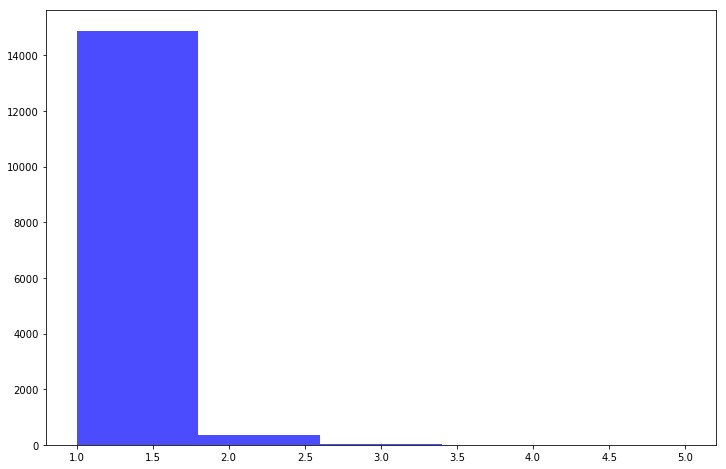

In [174]:
fig, ax = plt.subplots(figsize=(12,8))
    
ax.hist(data["num_reviews"] , bins= 5, alpha=0.7, color="blue")

In [109]:
print user_list

[u'AGuyCalledSquid', u'towerofmistakes', u'symb0lic', u'Dancool000', u'SUCKMYPOKEMON', u'takt1kal', u'Mr_Tyger', u'Heights', u'b4theserverowner', u'strajerul', u'spysappanmahprofile', u'daemonisk', u'plyrstar93', u'76561198053842338', u'76561198141241001', u'iv2b', u'MonthOLDpickle', u'76561198198556297', u'asvultian', u'76561198006528453', u'76561198122278483', u'Brocid3nkingofthebrocean', u'76561198061863902', u'76561198046095914', u'Slaughterrific', u'Yourproject', u'76561198001293673', u'berand', u'StubbornDeer', u'cozmoz26', u'TheOnlyNexusSix', u'HaveuseenDragon', u'espernyan', u'Jeshiivii', u'76561198133601657', u'76561198210821975', u'100kallibur', u'yyyyyes', u'AverageDragonair', u'76561198211867471', u'PidedPiper', u'yungian', u'AG_HACK', u'phraek', u'revolterxvii', u'sleepingbear123', u'76561197993148399', u'Phoenix297', u'muffinman80', u'ChefMcSexy', u'76561197967626603', u'Fistula', u'r3f1n3d', u'76561198156719677', u'76561198093989277', u'76561198064599921', u'thebridgetro

In [110]:
user_list.index("AGuyCalledSquid")

0

In [128]:
# add one to shape for the user name
test = pd.DataFrame(np.zeros(shape=(len(users), (source_collection.find().count() + 1 ))))
test.columns = columns

test["user"] = user_list

In [129]:
test.head(20)

,user,413150,367520,286160,246620,257850,105600,211820,311690,233450,250760
0,AGuyCalledSquid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,towerofmistakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,symb0lic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Dancool000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SUCKMYPOKEMON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,takt1kal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Mr_Tyger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,b4theserverowner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,strajerul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
boink = [1,2,3,4,5]
result = reduce(lambda x: x**2, boink)

TypeError: <lambda>() takes exactly 1 argument (2 given)

In [3]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
x = time.time()

In [9]:
x

1499292390.883157

In [16]:
"{:2.0f}".format(x)[-6:]

'292391'

In [24]:
from game_indexer import GameIndexer

ImportError: No module named game_indexer